# Titanic - KPMG szakmai feladat

**Legjobb eredmény : 83,1 % accuracy**

**Baseline-nak használt notebook:** https://www.kaggle.com/kenjee/titanic-project-example

A SVM-et és k-NN-t nem véletlenszerűen választottam ki az eredeti notebook algoritmusai közül. Elsősorban statisztikai tanuláselméleti hátterük (konzisztencia, reproducing kernel Hilbert spaces, representer theorem), továbbá amiatt a kérés miatt, hogy amennyire lehetséges a modell maradjon egyszerű.

A kevés adat miatt a mély tanulással kapcsolatos modellek fel sem merültek a feladat megoldása közben.

## Áttekintés 
### 1) Statisztikai elemzések

### 2) Feature Engineering 

### 3) Preprocesszálás (Adattisztítás + Feature-k véglegesítése)

### 4) Modell építése 

### 5) Modell optimalizálás

### 6) Ensemble Modell 

### 7) Eredmények

In [81]:
import numpy as np 
import pandas as pd 
import seaborn as sns 

import matplotlib.pyplot as plt
%matplotlib inline

### titanic.zip fájl kicsomagolása

In [82]:
from zipfile import ZipFile

ZIP_FILE_NAME = 'titanic.zip'

with ZipFile(ZIP_FILE_NAME,'r') as zip:
    zip.printdir()
    
    print('File-ok kicsomagolása...')
    zip.extractall()
    print('Kész!')

File Name                                             Modified             Size
DA_titanic_test.csv                            2020-09-25 11:59:14        19827
DA_titanic_train.csv                           2020-09-25 11:58:52        48431
File-ok kicsomagolása...
Kész!


### Adatok beolvasása

In [83]:
TRAIN_FILE = 'DA_titanic_train.csv'
TEST_FILE = 'DA_titanic_test.csv'

train = pd.read_csv(TRAIN_FILE, index_col = 'PassengerId')
test = pd.read_csv(TEST_FILE, index_col = 'PassengerId')

train['train_test'] = 1 #Tanító adatok
test['train_test'] = 0 #Nem tanító adatok
test['Survived'] = np.NaN

all_data = pd.concat([train,test])

all_data.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'train_test'],
      dtype='object')

In [84]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,1


## Statisztikai elemzések

In [85]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 624 entries, 1 to 891
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    624 non-null    int64  
 1   Pclass      624 non-null    int64  
 2   Name        624 non-null    object 
 3   Sex         624 non-null    object 
 4   Age         494 non-null    float64
 5   SibSp       624 non-null    int64  
 6   Parch       624 non-null    int64  
 7   Ticket      624 non-null    object 
 8   Fare        624 non-null    float64
 9   Cabin       128 non-null    object 
 10  Embarked    623 non-null    object 
 11  train_test  624 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 63.4+ KB


In [86]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267 entries, 4 to 890
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      267 non-null    int64  
 1   Name        267 non-null    object 
 2   Sex         267 non-null    object 
 3   Age         220 non-null    float64
 4   SibSp       267 non-null    int64  
 5   Parch       267 non-null    int64  
 6   Ticket      267 non-null    object 
 7   Fare        267 non-null    float64
 8   Cabin       76 non-null     object 
 9   Embarked    266 non-null    object 
 10  train_test  267 non-null    int64  
 11  Survived    0 non-null      float64
dtypes: float64(3), int64(4), object(5)
memory usage: 27.1+ KB


In [87]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,train_test
count,624.000000,624.000000,494.000000,624.000000,624.000000,624.000000,624.0
mean,0.383013,2.328526,29.658745,0.519231,0.354167,30.523470,1.0
std,0.486511,0.822684,14.770773,1.071871,0.775559,48.186064,0.0
min,0.000000,1.000000,0.670000,0.000000,0.000000,0.000000,1.0
25%,0.000000,2.000000,20.000000,0.000000,0.000000,7.895800,1.0
50%,0.000000,3.000000,28.000000,0.000000,0.000000,13.931250,1.0
75%,1.000000,3.000000,38.000000,1.000000,0.000000,30.000000,1.0
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.0


In [88]:
test.describe()

,Pclass,Age,SibSp,Parch,Fare,train_test,Survived
count,267.000000,220.000000,267.000000,267.000000,267.000000,267.0,0.0
mean,2.262172,29.789773,0.531835,0.445693,36.132224,0.0,NaN
std,0.866346,13.995008,1.173773,0.871354,52.935439,0.0,NaN
min,1.000000,0.420000,0.000000,0.000000,0.000000,0.0,NaN
25%,1.000000,21.000000,0.000000,0.000000,8.050000,0.0,NaN
50%,3.000000,29.000000,0.000000,0.000000,16.100000,0.0,NaN
75%,3.000000,39.000000,1.000000,1.000000,36.125000,0.0,NaN
max,3.000000,70.000000,8.000000,5.000000,512.329200,0.0,NaN


In [89]:
df_num = train[['Age','SibSp','Parch','Fare']] #Numerical
df_cat = train[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']] #Categorical

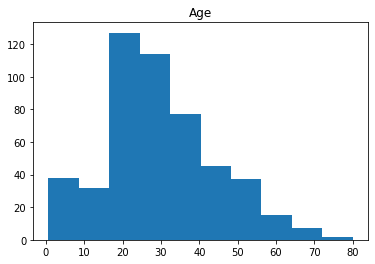

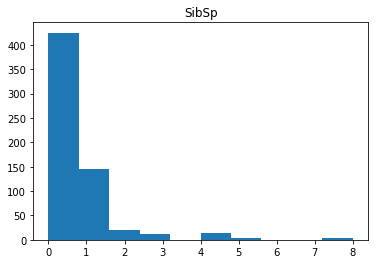

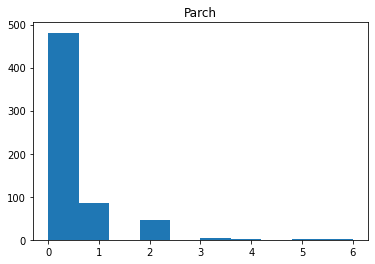

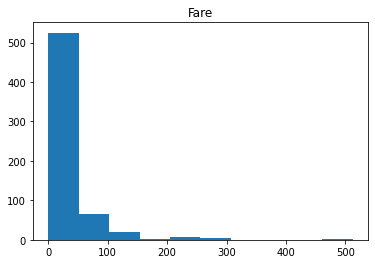

In [90]:
#Numerical feature-k hisztogramjai 
for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

            Age     SibSp     Parch      Fare
Age    1.000000 -0.297896 -0.196080  0.142341
SibSp -0.297896  1.000000  0.434930  0.165351
Parch -0.196080  0.434930  1.000000  0.209408
Fare   0.142341  0.165351  0.209408  1.000000


<AxesSubplot:>

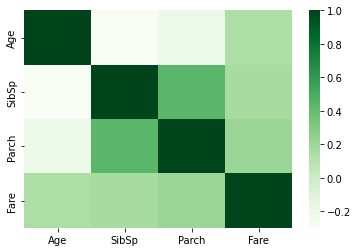

In [91]:
print(df_num.corr())
sns.heatmap(df_num.corr(),cmap="Greens") #Korrelációs mátrix

In [92]:
# Túlélési arányok megoszlása - Age, SibSp, Parch és Fare szerint 
pd.pivot_table(train, index = 'Survived', values = ['Age','SibSp','Parch','Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.030612,19.702488,0.296104,0.535065
1,29.112100,47.954760,0.447699,0.493724


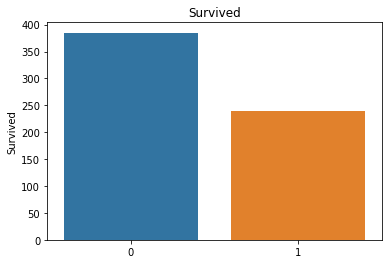

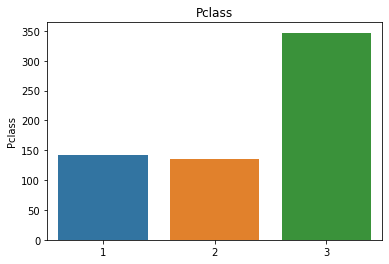

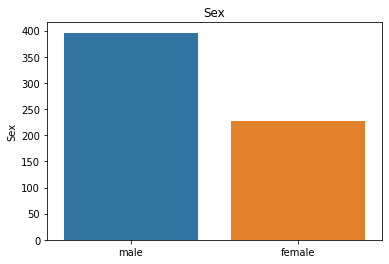

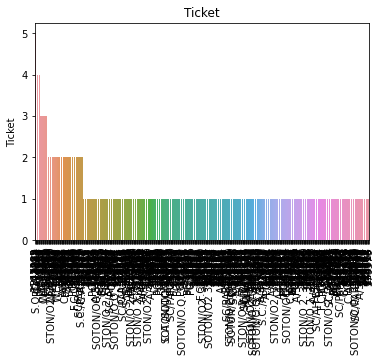

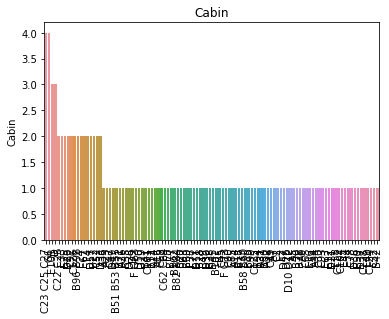

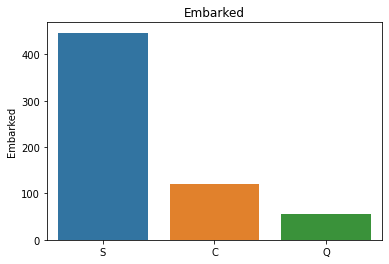

In [93]:

for i in df_cat.columns:
    sns_bp = sns.barplot(x = df_cat[i].value_counts().index,y = df_cat[i].value_counts())
    sns_bp.set_title(i)
    
    if i == 'Cabin' or i == 'Ticket':
        plt.setp(sns_bp.get_xticklabels(),rotation = 90)
    
    plt.show()\
    

Cabin and ticket graphs are very messy. This is an area where we may want to do some feature engineering! 

In [94]:
# Comparing survival and each of these categorical variables 
print(pd.pivot_table(train, index = 'Survived', columns = 'Pclass', values = 'Ticket' ,aggfunc ='count'))
print()
print(pd.pivot_table(train, index = 'Survived', columns = 'Sex', values = 'Ticket' ,aggfunc ='count'))
print()
print(pd.pivot_table(train, index = 'Survived', columns = 'Embarked', values = 'Ticket' ,aggfunc ='count'))

Pclass     1   2    3
Survived             
0         46  73  266
1         96  62   81

Sex       female  male
Survived              
0             60   325
1            168    71

Embarked   C   Q    S
Survived             
0         52  33  300
1         69  22  147


## Feature Engineering 

In [95]:
train['cabin_adv'] = train.Cabin.apply(lambda x: str(x)[0])

In [96]:
#Comparing surivial rate by cabin
print(train.cabin_adv.value_counts())
pd.pivot_table(train,index='Survived',columns='cabin_adv', values = 'Name', aggfunc='count')

n    496
C     33
B     26
D     23
E     23
A     12
F      7
G      4
Name: cabin_adv, dtype: int64


cabin_adv,A,B,C,D,E,F,G,n
Survived,,,,,,,,
0,6,7,9,4,5,4,2,348
1,6,19,24,19,18,3,2,148


In [97]:
train['name_title'] = train.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
#mr., ms., master. etc

In [98]:
train['name_title'].value_counts()

Mr              357
Miss            128
Mrs              94
Master           24
Rev               5
Dr                5
Major             2
Mlle              2
Don               1
Ms                1
Lady              1
Col               1
Capt              1
the Countess      1
Jonkheer          1
Name: name_title, dtype: int64

## Preprocesszálás

(623,)

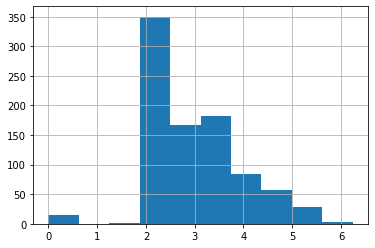

In [99]:
# Preprocesszáljuk mind a tanító, mind pedig a teszt adatokat is. Ennek a legegyszerűbb módja, ha egyszerre végezzük el
# a transzformációkat a kód elején létrehozott all_data-n!
all_data['cabin_adv'] = all_data.Cabin.apply(lambda x: str(x)[0])
all_data['name_title'] = all_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

# Age
# Null értékek feltöltése a mediánnal
#all_data.Age = all_data.Age.fillna(training.Age.mean())
all_data.Age = all_data.Age.fillna(train.Age.median())

#Töröljük azt a sort, ahol null értékünk van az Embarked oszlopban (1 a tanító halmazban és 1 a teszt halmazban)
all_data.dropna(subset=['Embarked'],inplace = True)

# log norm of fare
all_data['norm_fare'] = np.log(all_data.Fare+1)
all_data['norm_fare'].hist()

# converted fare to category for pd.get_dummies()
all_data.Pclass = all_data.Pclass.astype(str)

#created dummy variables from categories (also can use OneHotEncoder)
all_dummies = pd.get_dummies(all_data[['Pclass','Sex','Age','SibSp','Parch','norm_fare','Embarked','cabin_adv','name_title','train_test']])

#Split to train test again
X_train = all_dummies[all_dummies.train_test == 1].drop(['train_test'], axis =1)
X_test = all_dummies[all_dummies.train_test == 0].drop(['train_test'], axis =1)


y_train = all_data[all_data.train_test==1].Survived
y_train.shape

In [100]:
# Scale data 
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
all_dummies_scaled = all_dummies.copy()
all_dummies_scaled[['Age','SibSp','Parch','norm_fare']]= scale.fit_transform(all_dummies_scaled[['Age','SibSp','Parch','norm_fare']])
all_dummies_scaled

X_train_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 1].drop(['train_test'], axis =1)
X_test_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 0].drop(['train_test'], axis =1)

y_train = all_data[all_data.train_test==1].Survived


## Tanítás - Baseline modellek

- K Nearest Neighbor (82.0%)
- **Support Vector Classifier (82.3%)**
- Soft Voting Classifier (k-NN, SVM) (81.8%)

In [101]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [102]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.808      0.824      0.816      0.74193548 0.87903226]
0.8137935483870967


In [103]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.784      0.8        0.84       0.81451613 0.86290323]
0.8202838709677419


In [104]:
svc = SVC(probability = True)
cv = cross_val_score(svc,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.824      0.832      0.84       0.75       0.87096774]
0.8233935483870967


In [105]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators = [('knn',knn),('svc',svc)], voting = 'soft') 

In [106]:
cv = cross_val_score(voting_clf,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.792      0.832      0.832      0.76612903 0.87096774]
0.8186193548387097


## Modell optimalizálás

|Model|Baseline|Tuned Performance|
|-----|--------|-----------------|
|K Nearest Neighbor| 82.0%|83.1%|
|Support Vector Classifier| 82.3%| 82.3%|


In [107]:
from sklearn.model_selection import GridSearchCV 

In [108]:
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [109]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7,9],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2]}
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(X_train_scaled,y_train)
clf_performance(best_clf_knn,'KNN')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
KNN
Best Score: 0.8314838709677419
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}


In [110]:
svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
                                  'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100, 1000]}]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(X_train_scaled,y_train)
clf_performance(best_clf_svc,'SVC')

Fitting 5 folds for each of 55 candidates, totalling 275 fits
SVC
Best Score: 0.8233806451612903
Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


## Ensemble Modell 
1) Voting Classifier - hard voting (k-NN, SVM) (81.3%)

2) **Voting Classifier - soft voting - súlyok: [3,1] (k-NN, SVM) (82.9%)**

3) Voting Classifier - soft voting (k-NN, SVM) (82.0%)

Ebben az esetben minimális 0,1 %-os különbség lehetséges különböző futtatások között!

In [111]:
best_knn = best_clf_knn.best_estimator_
best_svc = best_clf_svc.best_estimator_

voting_clf_hard = VotingClassifier(estimators = [('knn',best_knn),('svc',best_svc)], voting = 'hard') 
voting_clf_soft = VotingClassifier(estimators = [('knn',best_knn),('svc',best_svc)], voting = 'soft') 

print('voting_clf_hard :',cross_val_score(voting_clf_hard,X_train,y_train,cv=5))
print('voting_clf_hard mean :',cross_val_score(voting_clf_hard,X_train,y_train,cv=5).mean())

print('voting_clf_soft :',cross_val_score(voting_clf_soft,X_train,y_train,cv=5))
print('voting_clf_soft mean :',cross_val_score(voting_clf_soft,X_train,y_train,cv=5).mean())


voting_clf_hard : [0.808      0.824      0.8        0.76612903 0.87096774]
voting_clf_hard mean : 0.8138193548387097
voting_clf_soft : [0.816      0.816      0.84       0.76612903 0.87096774]
voting_clf_soft mean : 0.8202193548387097


In [112]:
params = {'weights' : [[1,1],[2,1],[1,2],[3,1],[1,3]]}

vote_weight = GridSearchCV(voting_clf_soft, param_grid = params, cv = 5, verbose = True, n_jobs = -1)
best_clf_weight = vote_weight.fit(X_train_scaled,y_train)
clf_performance(best_clf_weight,'VC Weights')
voting_clf_sub = best_clf_weight.best_estimator_.predict(X_test_scaled)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
VC Weights
Best Score: 0.8298709677419355
Best Parameters: {'weights': [3, 1]}


In [113]:
#Tanítás 
best_knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=9, p=1)

## Eredmény

In [114]:
test.drop(['train_test'],axis = 1)
test.dropna(subset=['Embarked'],inplace = True)

test['Survived'] = best_knn.predict(X_test_scaled) #Predikció - az optimalizált k-NN bizonyult a legjobb modellnek
# természetesen további metrikák vizsgálatára is szükség lenne, mivel abban az esetben, ha csak az accuracy-t vizsgáljuk
# tévútra térhetünk a legtöbb esetben

test.to_csv('test_predictions.csv') #Eredmények elmentése

In [115]:
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test,Survived
PassengerId,,,,,,,,,,,,
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,1.0
6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0,0.0
7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0,1.0
8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,0,0.0
9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,0,0.0
